In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [ ]:
df = pd.read_csv("data_1.csv")

/tmp/ipython-input-829710678.py:1: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data_1.csv")


In [ ]:
df = df.sample(n=500000,random_state=42).reset_index(drop=True)

In [ ]:
df.head()

,pkSeqID,stime,flgs,proto,saddr,sport,daddr,dport,pkts,bytes,...,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack,category,subcategory
0,322312,1.526881e+09,e,tcp,192.168.100.149,57044,192.168.100.3,64776,2,120,...,1,1,60,60,20.742584,0.0,0.0,1,Reconnaissance,Service_Scan
1,605414,1.526899e+09,e,tcp,192.168.100.149,40081,192.168.100.3,64679,2,120,...,1,1,60,60,25.742014,0.0,0.0,1,Reconnaissance,Service_Scan
2,529834,1.526899e+09,e,tcp,192.168.100.147,65233.0,192.168.100.3,24973.0,2,120,...,1,1,60,60,1019.367981,0.0,0.0,1,Reconnaissance,Service_Scan
3,432267,1.526881e+09,e,tcp,192.168.100.148,65131,192.168.100.3,1053,2,120,...,1,1,60,60,47619.046875,0.0,0.0,1,Reconnaissance,Service_Scan
4,39496,1.526348e+09,e,tcp,192.168.100.150,56972,192.168.100.5,873,2,120,...,1,1,60,60,2309.468750,0.0,0.0,1,Reconnaissance,Service_Scan


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 35 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   pkSeqID       500000 non-null  int64  
 1   stime         500000 non-null  float64
 2   flgs          500000 non-null  object 
 3   proto         500000 non-null  object 
 4   saddr         500000 non-null  object 
 5   sport         499755 non-null  object 
 6   daddr         500000 non-null  object 
 7   dport         499755 non-null  object 
 8   pkts          500000 non-null  int64  
 9   bytes         500000 non-null  int64  
 10  state         500000 non-null  object 
 11  ltime         500000 non-null  float64
 12  seq           500000 non-null  int64  
 13  dur           500000 non-null  float64
 14  mean          500000 non-null  float64
 15  stddev        500000 non-null  float64
 16  smac          0 non-null       float64
 17  dmac          0 non-null       float64
 18  sum 

In [ ]:
print(df["attack"].value_counts())

attack
1    498885
0      1115
Name: count, dtype: int64


### FEATURE SELECTION

In [ ]:
FEATURES = [
    "proto", "state", "flgs",
    "sport", "dport",
    "pkts", "bytes", "dur",
    "spkts", "dpkts",
    "sbytes", "dbytes",
    "mean", "stddev", "min", "max", "sum",
    "rate", "srate", "drate"
]

TARGET = "attack"

In [ ]:
df = df[FEATURES + [TARGET]]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   proto   500000 non-null  object 
 1   state   500000 non-null  object 
 2   flgs    500000 non-null  object 
 3   sport   499755 non-null  object 
 4   dport   499755 non-null  object 
 5   pkts    500000 non-null  int64  
 6   bytes   500000 non-null  int64  
 7   dur     500000 non-null  float64
 8   spkts   500000 non-null  int64  
 9   dpkts   500000 non-null  int64  
 10  sbytes  500000 non-null  int64  
 11  dbytes  500000 non-null  int64  
 12  mean    500000 non-null  float64
 13  stddev  500000 non-null  float64
 14  min     500000 non-null  float64
 15  max     500000 non-null  float64
 16  sum     500000 non-null  float64
 17  rate    500000 non-null  float64
 18  srate   500000 non-null  float64
 19  drate   500000 non-null  float64
 20  attack  500000 non-null  int64  
dtypes: float64

In [ ]:
df.columns

Index(['proto', 'state', 'flgs', 'sport', 'dport', 'pkts', 'bytes', 'dur',
       'spkts', 'dpkts', 'sbytes', 'dbytes', 'mean', 'stddev', 'min', 'max',
       'sum', 'rate', 'srate', 'drate', 'attack'],
      dtype='object')

In [ ]:
print(df.isna().sum())

proto       0
state       0
flgs        0
sport     245
dport     245
pkts        0
bytes       0
dur         0
spkts       0
dpkts       0
sbytes      0
dbytes      0
mean        0
stddev      0
min         0
max         0
sum         0
rate        0
srate       0
drate       0
attack      0
dtype: int64


In [ ]:
df = df.dropna()

In [ ]:
df.shape

(499755, 21)

In [ ]:
categorical_features = ["proto", "state", "flgs"]

numeric_features = [
    "sport", "dport", "pkts", "bytes", "dur",
    "spkts", "dpkts", "sbytes", "dbytes",
    "mean", "stddev", "min", "max", "sum",
    "rate", "srate", "drate"
]

In [ ]:
print(df[categorical_features].dtypes)
print(df[numeric_features].dtypes)


proto    object
state    object
flgs     object
dtype: object
sport      object
dport      object
pkts        int64
bytes       int64
dur       float64
spkts       int64
dpkts       int64
sbytes      int64
dbytes      int64
mean      float64
stddev    float64
min       float64
max       float64
sum       float64
rate      float64
srate     float64
drate     float64
dtype: object


In [ ]:
df["sport"] = pd.to_numeric(df["sport"], errors="coerce")
df["dport"] = pd.to_numeric(df["dport"], errors="coerce")
df["flgs"] = df["flgs"].astype(str)

In [ ]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y )

In [ ]:
categorical_pipeline = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

numeric_pipline = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median"))
])

In [ ]:
preprocessor=ColumnTransformer(
    transformers=[
        ("cat",categorical_pipeline,categorical_features),
        ("num",numeric_pipline,numeric_features)
    ]
)

In [ ]:
rf = Pipeline(
    steps=[
        ("preprocess",preprocessor),
        ("model",RandomForestClassifier
         (n_estimators=150,
          max_depth=15,
          class_weight="balanced",
          random_state=42,
          n_jobs=-1)
         )
    ]
)

In [ ]:
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

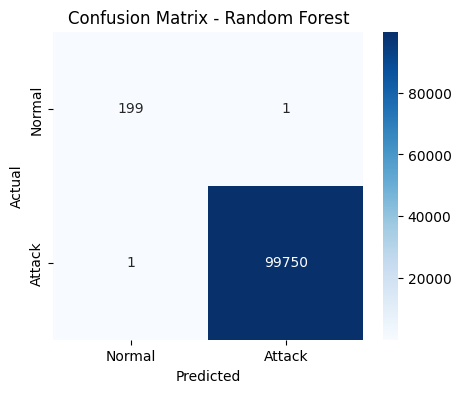

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Attack"],
            yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
[[  199     1]
 [    1 99750]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9950    0.9950    0.9950       200
           1     1.0000    1.0000    1.0000     99751

    accuracy                         1.0000     99951
   macro avg     0.9975    0.9975    0.9975     99951
weighted avg     1.0000    1.0000    1.0000     99951

ROC-AUC: 0.9999971930105964


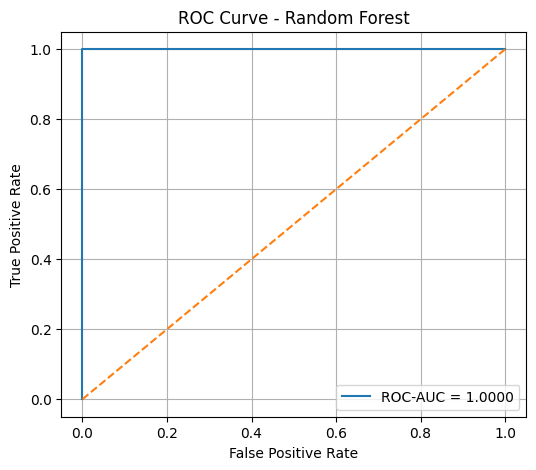

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()

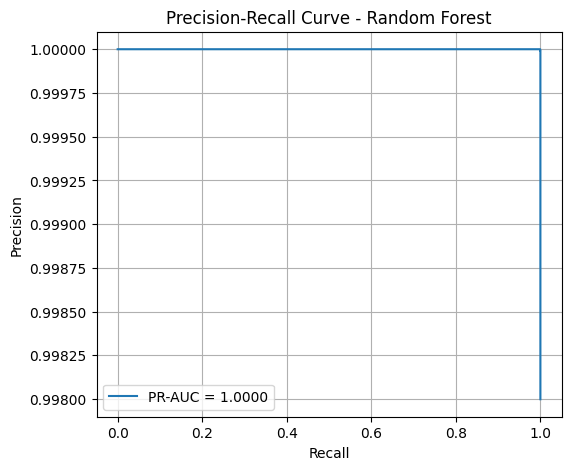

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR-AUC = {average_precision_score(y_test, y_prob):.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Random Forest")
plt.legend()
plt.grid()
plt.show()


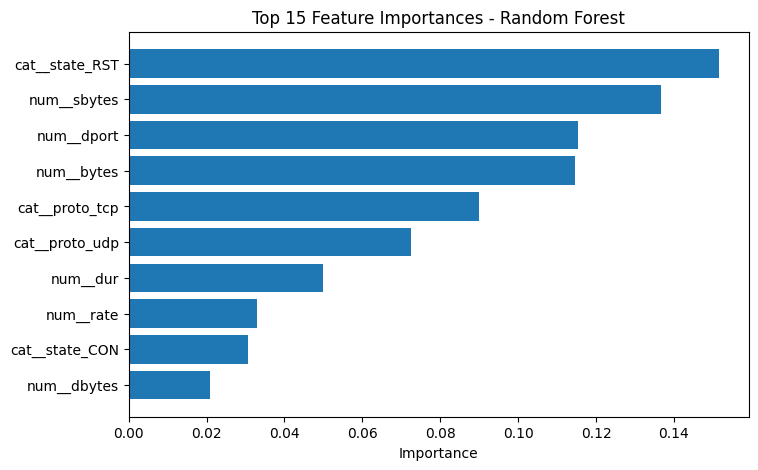

In [ ]:
feature_names = rf.named_steps["preprocess"].get_feature_names_out()
importances = rf.named_steps["model"].feature_importances_

imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(imp_df["feature"], imp_df["importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.show()

Isolation Forest

In [ ]:
iso_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", IsolationForest(
        n_estimators=100,
        contamination=0.01,
        random_state=42,
        n_jobs=-1
    ))
])

In [ ]:
iso_pipeline.fit(X_train)

iso_pred = iso_pipeline.predict(X_test)
iso_pred = np.where(iso_pred == -1, 1, 0)

print("Isolation Forest Confusion Matrix:")
print(confusion_matrix(y_test, iso_pred))
print(classification_report(y_test, iso_pred))

Isolation Forest Confusion Matrix:
[[  170    30]
 [98826   925]]
              precision    recall  f1-score   support

           0       0.00      0.85      0.00       200
           1       0.97      0.01      0.02     99751

    accuracy                           0.01     99951
   macro avg       0.49      0.43      0.01     99951
weighted avg       0.97      0.01      0.02     99951



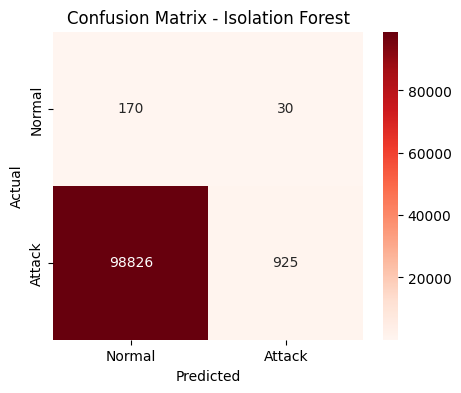

In [40]:
cm_iso = confusion_matrix(y_test, iso_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_iso, annot=True, fmt="d", cmap="Reds",
            xticklabels=["Normal", "Attack"],
            yticklabels=["Normal", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Isolation Forest")
plt.show()


 Isolation Forest detects anomalies, not “attack classes”.

Most data is normal, anomalies are rare
- But in BoT-IoT:
- 99.8% = attacks
- 0.2% = normal

Model Comparison(RF vs Isolation Forest)

| Model            | Recall (Attack) | Precision | Notes        |
| ---------------- | --------------- | --------- | ------------ |
| Random Forest    | ~1.00           | ~1.00     | Supervised   |
| Isolation Forest | ~0.01           | ~0.95     | Unsupervised |


In [41]:
import joblib
joblib.dump(rf,"rfmodel.pkl")

['rfmodel.pkl']